<a href="https://colab.research.google.com/github/honyango/Analog-World-Clock/blob/master/Copy_of_Model_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [13]:
from google.colab import drive
drive.mount('/content/drive')

# Install libraries if needed
!pip install opencv-python-headless pandas

import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split  # For custom splits if needed

# Define the base path for the dataset
base_path = '/content/drive/MyDrive/Alzheimers Detection Dataset/Alzheimers_Detection_dataset/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load and explore CSVs to verify class balances:

In [2]:
import os

directory_path = '/content/drive/MyDrive/Alzheimers Detection Dataset/Alzheimers_Detection_dataset/'

if os.path.exists(directory_path):
    files_in_directory = os.listdir(directory_path)
    print(f"Files in '{directory_path}':")
    for file_name in files_in_directory:
        print(file_name)
else:
    print(f"The directory '{directory_path}' does not exist.")

Files in '/content/drive/MyDrive/Alzheimers Detection Dataset/Alzheimers_Detection_dataset/':
CSV_datafiles
test
valid
train


In [8]:
# STEP 1: Install required packages
!pip install tensorflow tqdm --quiet

# STEP 2: Import libraries
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from tqdm import tqdm

# STEP 3: Define paths
input_root = '/content/drive/MyDrive/Alzheimers Detection Dataset/Alzheimers_Detection_dataset/train'     # Your image dataset path
output_root = '/content/Alzheimers_Detection_dataset'    # Output folder for segmentation masks
os.makedirs(output_root, exist_ok=True)

# STEP 4: Preprocessing function
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB').resize((128, 128))
    image_array = np.array(image) / 255.0
    return np.expand_dims(image_array, axis=0), image.size

# STEP 5: Dummy segmentation model (replace this with real model later)
def dummy_segmentation_model(image_tensor):
    # Simple red channel threshold for demo purposes
    mask = (image_tensor[0][:, :, 0] > 0.5).astype(np.uint8) * 255
    return mask

# Optional: Load real segmentation model here (uncomment when using real model)
# model = tf.keras.models.load_model('/content/unet_model.h5')

# STEP 6 & 7: Process each image (assuming a flat structure directly in input_root)
# The previous logic incorrectly assumed subfolders for classes within input_root.
for img_name in tqdm(os.listdir(input_root), desc=f"Processing images in {input_root}"):
    img_path = os.path.join(input_root, img_name)

    # Skip directories or non-image files
    if os.path.isdir(img_path) or not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue

    try:
        img_tensor, original_size = preprocess_image(img_path)

        # Dummy segmentation
        mask = dummy_segmentation_model(img_tensor)

        # Resize mask back to original image size and save directly to output_root
        mask_image = Image.fromarray(mask).resize(original_size)
        mask_image.save(os.path.join(output_root, img_name))

    except Exception as e:
        print(f"❌ Failed to process {img_path}: {e}")

Processing images in /content/drive/MyDrive/Alzheimers Detection Dataset/Alzheimers_Detection_dataset/train: 100%|██████████| 8960/8960 [04:11<00:00, 35.60it/s] 


In [23]:
# STEP 3: Image size and parameters
image_size = 224
input_shape = (image_size, image_size, 3)
batch_size = 32
dataset_path = input_root # Use the previously defined input_root for the dataset path

# Dynamically determine num_classes from the loaded CSV
# Assuming train_csv is a pandas DataFrame loaded from _train_classes.csv
# and contains 'filename' column plus one-hot encoded class columns.
class_cols = train_csv.columns.drop('filename').tolist()
num_classes = len(class_cols) # This will correctly be 4

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Get class labels from train_csv (assuming train_csv is already loaded)
class_cols = train_csv.columns.drop('filename').tolist()

# Create a single column with string labels for flow_from_dataframe
# This bypasses a type checking issue in flow_from_dataframe when y_col is a list of numerical columns.
train_csv['class_label'] = train_csv[class_cols].idxmax(axis=1)

# STEP 4: Create train and validation generators
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2 # This will be applied to the dataframe.
)

# The image files are located in `dataset_path` (which is `input_root`),
# and their labels are in `train_csv`.
train_generator = datagen.flow_from_dataframe(
    dataframe=train_csv,
    directory=dataset_path,
    x_col='filename',
    y_col='class_label', # Use the new single class label column
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_dataframe(
    dataframe=train_csv,
    directory=dataset_path,
    x_col='filename',
    y_col='class_label', # Use the new single class label column
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 7168 validated image filenames belonging to 4 classes.
Found 1792 validated image filenames belonging to 4 classes.


In [25]:
# STEP 5: Build your CNN model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
# STEP 6: Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# STEP 7: Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 759s 3s/step - accuracy: 0.4607 - loss: 1.1045 - val_accuracy: 0.6423 - val_loss: 0.8737
Epoch 2/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 751s 3s/step - accuracy: 0.5467 - loss: 0.9538 - val_accuracy: 0.5999 - val_loss: 0.8338
Epoch 3/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 750s 3s/step - accuracy: 0.5810 - loss: 0.8743 - val_accuracy: 0.5820 - val_loss: 0.7816
Epoch 4/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 743s 3s/step - accuracy: 0.6435 - loss: 0.7684 - val_accuracy: 0.6819 - val_loss: 0.6632
Epoch 5/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 758s 3s/step - accuracy: 0.6987 - loss: 0.6705 - val_accuracy: 0.7126 - val_loss: 0.6211
Epoch 6/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 742s 3s/step - accuracy: 0.7507 - loss: 0.5538 - val_accuracy: 0.7215 - val_loss: 0.6191
Epoch 7/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 735s 3s/step - accuracy: 0.7997 - loss: 0.4761 - val_accuracy: 0.7037 - val_loss: 0.7378
Epoch 8/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 739s 3s/step - accuracy: 0.8319 - loss: 0.3879 - val_accu

In [28]:
# STEP 8: Evaluate model
loss, acc = model.evaluate(val_generator)
print(f"\n✅ Validation Accuracy: {acc*100:.2f}%")

56/56 ━━━━━━━━━━━━━━━━━━━━ 56s 999ms/step - accuracy: 0.7453 - loss: 0.7009

✅ Validation Accuracy: 75.95%


In [36]:
from sklearn.metrics import classification_report
import numpy as np # Import numpy for arange

# STEP 9: Classification report
val_generator.reset()
preds = model.predict(val_generator, verbose=1)
y_pred = preds.argmax(axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

print("\nClassification Report:")
# Explicitly pass the 'labels' parameter to include all possible classes
# This tells the report to expect classes 0, 1, 2, 3 even if not all are in y_true.
print(classification_report(y_true, y_pred, target_names=class_labels, labels=np.arange(num_classes)))

56/56 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step

Classification Report:
              precision    recall  f1-score   support

          MD       0.00      0.00      0.00         3
         MoD       0.00      0.00      0.00         0
          ND       0.50      0.00      0.00      1139
         VMD       0.36      1.00      0.53       650

    accuracy                           0.36      1792
   macro avg       0.22      0.25      0.13      1792
weighted avg       0.45      0.36      0.20      1792



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

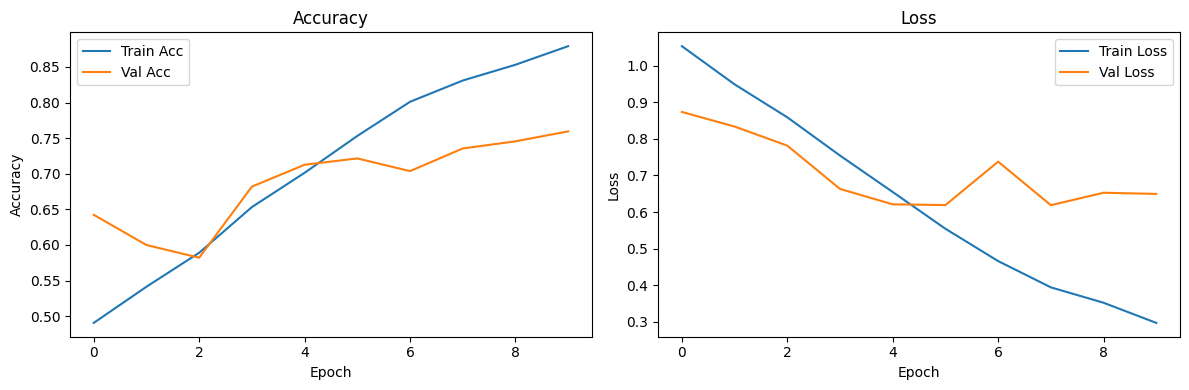

In [31]:
# STEP 11: Plot accuracy/loss curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


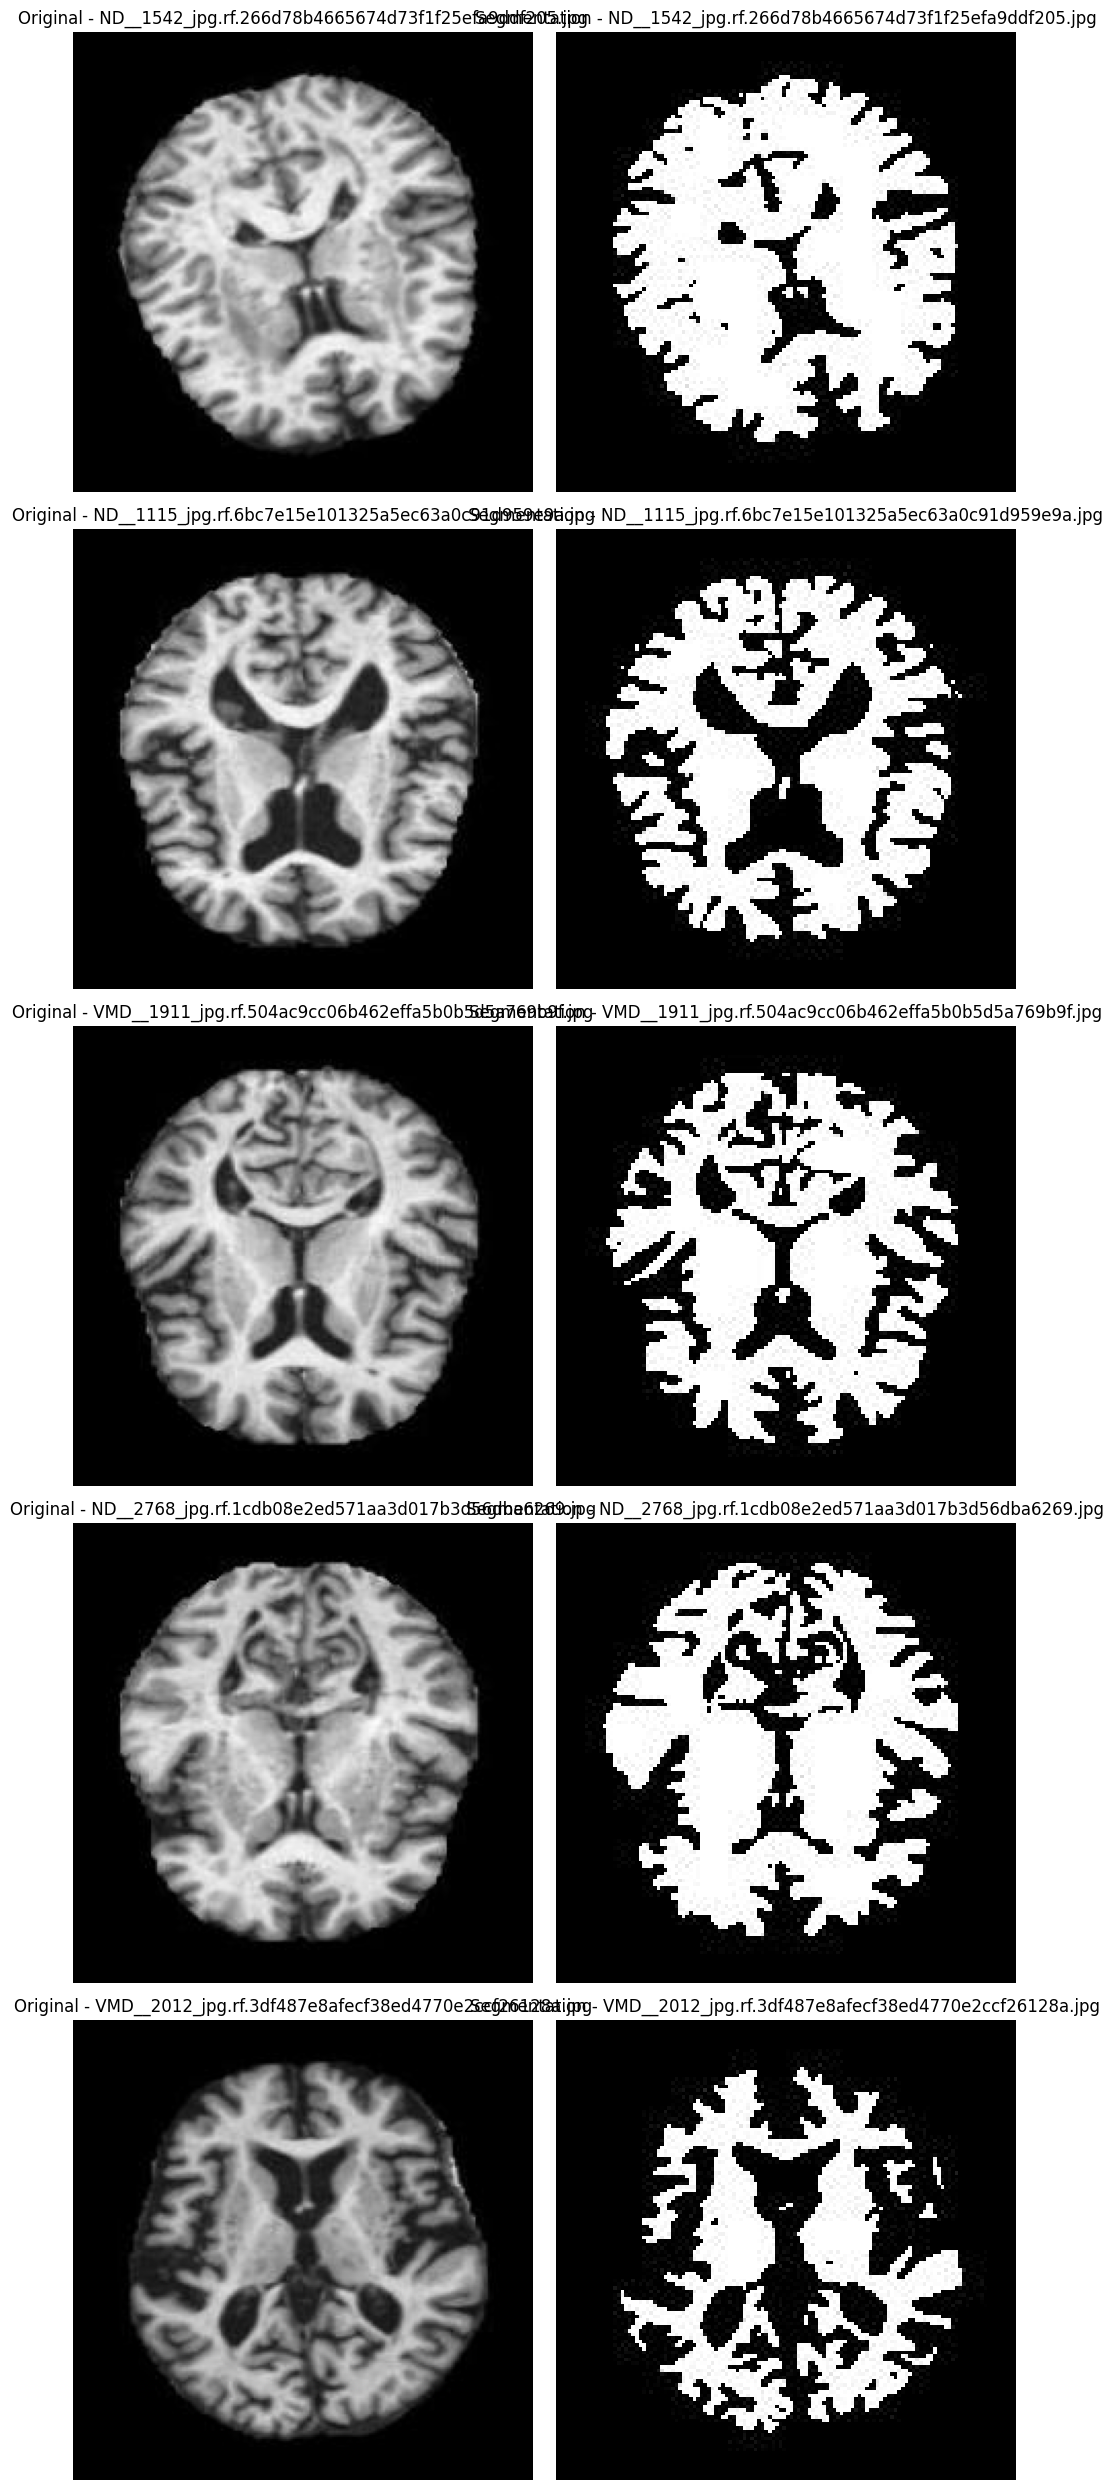

In [9]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Paths
original_path = '/content/drive/MyDrive/Alzheimers Detection Dataset/Alzheimers_Detection_dataset/train'
segmented_path = '/content/Alzheimers_Detection_dataset'

# How many samples to show
num_samples = 5

# Collect valid (image) pairs - assuming flat structure
samples = []
all_original_images = [f for f in os.listdir(original_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

for img_name in all_original_images:
    orig_img_path = os.path.join(original_path, img_name)
    seg_img_path = os.path.join(segmented_path, img_name)

    # Ensure both original and segmented images exist
    if os.path.exists(orig_img_path) and os.path.exists(seg_img_path):
        samples.append(img_name)

# Randomly select samples
selected_samples = random.sample(samples, min(num_samples, len(samples)))

# Plotting
# Check if selected_samples is empty to avoid ValueError
if not selected_samples:
    print("No samples found to display. Please ensure images were processed and saved correctly.")
else:
    fig, axes = plt.subplots(len(selected_samples), 2, figsize=(10, 5 * len(selected_samples)))

    # Adjust axes indexing if only one sample is selected
    if len(selected_samples) == 1:
        axes = [axes]

    for i, img_name in enumerate(selected_samples):
        orig_img = Image.open(os.path.join(original_path, img_name))
        seg_img = Image.open(os.path.join(segmented_path, img_name))

        axes[i][0].imshow(orig_img)
        axes[i][0].set_title(f"Original - {img_name}")
        axes[i][0].axis('off')

        axes[i][1].imshow(seg_img, cmap='gray') # Assuming segmentation masks are grayscale
        axes[i][1].set_title(f"Segmentation - {img_name}")
        axes[i][1].axis('off')

    plt.tight_layout()
    plt.show()

Load and explore CSVs to verify class balances

In [15]:
# The base_path is now defined in a previous cell.
# The previous attempt to load train_csv failed because the variable was not defined.
# Based on the directory listing and common dataset structures,
# the CSV files are likely located in the 'CSV_datafiles' sub-directory.
csv_full_path = os.path.join(base_path, 'CSV_datafiles', '_train_classes.csv')
train_csv = pd.read_csv(csv_full_path)

def load_image(folder, filename):
    img_path = os.path.join(base_path, folder, filename)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (256, 256))  # Resize
    img = img / 255.0  # Normalize [0,1]
    return img

# Example: Load a sample
# The train_csv is loaded above, so now this should work.
sample_img = load_image('train', train_csv['filename'].iloc[0])
print("Sample shape:", sample_img.shape)  # (256, 256, 3)

Sample shape: (256, 256, 3)


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# STEP 5: Build your CNN model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
# STEP 1: Install required packages
!pip install tensorflow tqdm --quiet

# STEP 2: Import libraries
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from tqdm import tqdm

# STEP 3: Define paths
input_root = '/content/selected_images'     # Your image dataset path
output_root = '/content/HAM_seg'    # Output folder for segmentation masks
os.makedirs(output_root, exist_ok=True)

# STEP 4: Preprocessing function
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB').resize((128, 128))
    image_array = np.array(image) / 255.0
    return np.expand_dims(image_array, axis=0), image.size

# STEP 5: Dummy segmentation model (replace this with real model later)
def dummy_segmentation_model(image_tensor):
    # Simple green channel threshold for demo purposes
    mask = (image_tensor[0][:, :, 1] > 0.5).astype(np.uint8) * 255
    return mask

# Optional: Load real segmentation model here (U-Net or custom model)
# model = tf.keras.models.load_model('/content/unet_model.h5')

# STEP 6: Iterate over all class folders
for class_name in os.listdir(input_root):
    class_input_path = os.path.join(input_root, class_name)

    # Skip non-directories like .DS_Store
    if not os.path.isdir(class_input_path):
        continue

    class_output_path = os.path.join(output_root, class_name)
    os.makedirs(class_output_path, exist_ok=True)

    # STEP 7: Process each image
    for img_name in tqdm(os.listdir(class_input_path), desc=f"Processing {class_name}"):
        img_path = os.path.join(class_input_path, img_name)

        # Skip non-image files
        if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        try:
            img_tensor, original_size = preprocess_image(img_path)

            # Real model prediction (uncomment when using real model)
            # prediction = model.predict(img_tensor)
            # mask = (prediction[0, :, :, 0] > 0.5).astype(np.uint8) * 255

            # Dummy segmentation
            mask = dummy_segmentation_model(img_tensor)

            # Resize mask back to original image size and save
            mask_image = Image.fromarray(mask).resize(original_size)
            mask_image.save(os.path.join(class_output_path, img_name))

        except Exception as e:
            print(f"❌ Failed to process {img_path}: {e}")


FileNotFoundError: [Errno 2] No such file or directory: '/content/selected_images'

For image loading and preprocessing (resizing, normalization)

In [ ]:
def load_image(folder, filename):
    img_path = os.path.join(base_path, folder, filename)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (256, 256))  # Resize
    img = img / 255.0  # Normalize [0,1]
    return img

# Example: Load a sample
sample_img = load_image('train', train_csv['filename'].iloc[0])
print("Sample shape:", sample_img.shape)  # (256, 256, 3)

Sample shape: (256, 256, 3)


Augmentation can use libraries like Albumentations:

In [ ]:
!pip install albumentations
import albumentations as A

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])

# Apply to sample
aug_img = transform(image=(sample_img * 255).astype('uint8'))['image'] / 255.0

For U-Net implementation (using Keras/TensorFlow, install if needed: !pip install tensorflow):

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout

def unet(input_size=(256,256,3)):
    inputs = Input(input_size)

    # Encoder path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder path
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2,2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2,2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2,2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2,2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same')(conv9)

    # Output layer for binary segmentation
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    return model

model = unet()
model.summary()  # Shows ~31M parameters

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 32,    │          0 │ conv2d_9[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 16, 16,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_4[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 16, 16,    │  9,438,208 │ conv2d_10[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_11[0][0] 

 Total params: 31,032,837 (118.38 MB)

 Trainable params: 31,032,837 (118.38 MB)

 Non-trainable params: 0 (0.00 B)